# M5 forecasting, EDA and LGBM prediction

### Libraries

In [ ]:
# Basic library
import numpy as np
import pandas as pd

import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
!pip install lightgbm

In [ ]:
# Visualization
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns

# Time series analysis
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

# Data preprocessing
from sklearn.model_selection import train_test_split

# Library
import lightgbm as lgb

# Grid search
from sklearn.model_selection import GridSearchCV

# Validataion
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data loading and checking

In [ ]:
# load master data
train_df = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
calendar_df = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
price_df = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
sample = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")

### data check

In [ ]:
# submission sample data
sample.head()

In [ ]:
# base training data
train_df.head()

In [ ]:
# item price data
price_df.head()

In [ ]:
# calendar data
calendar_df.head()

In [ ]:
# date object type change
calendar_df["date_dt"] = pd.to_datetime(calendar_df["date"])

### data size

In [ ]:
print("train data:{}".format(train_df.shape))
print("calendar data:{}".format(calendar_df.shape))
print("price data:{}".format(price_df.shape))
print("sample data:{}".format(sample.shape))

### Data relationships

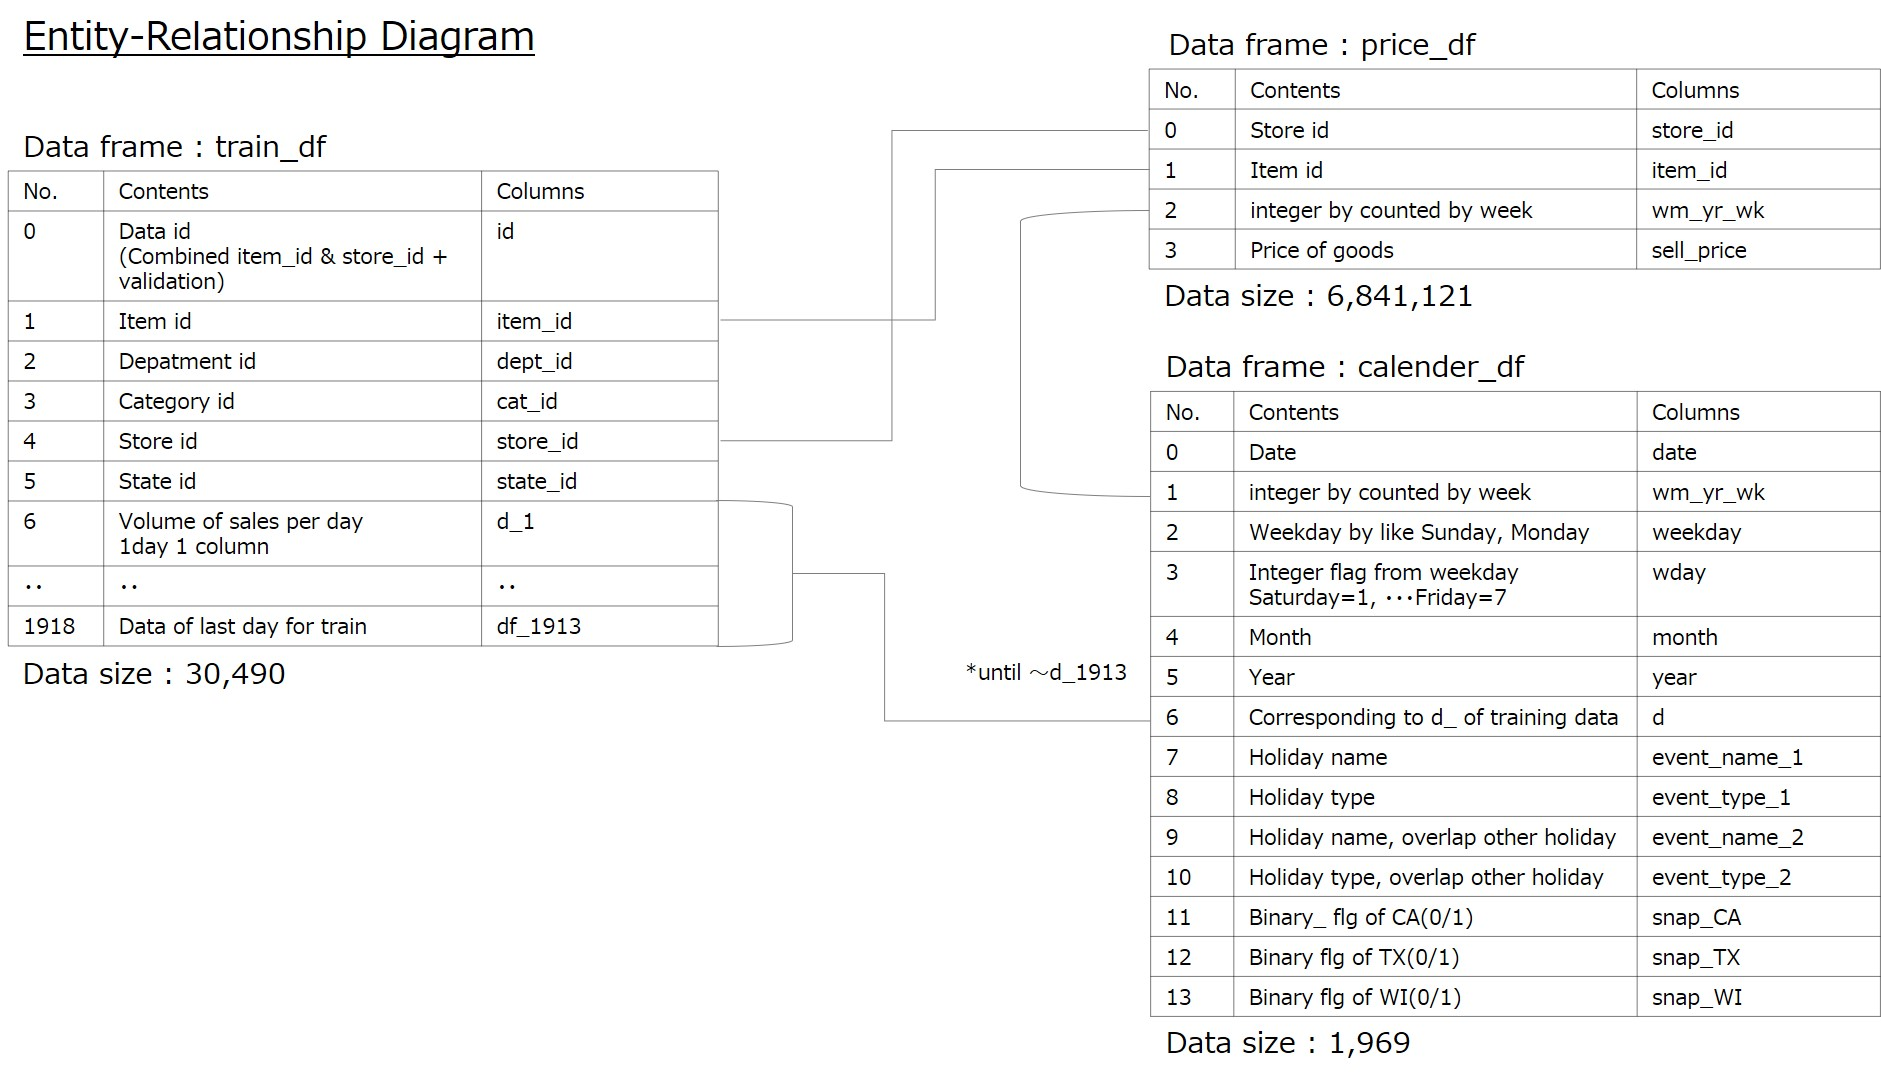

In [ ]:
# data copy
train  = train_df.copy()
price = price_df.copy()
calendar = calendar_df.copy()

# Price data EDA

Unique value counts

In [ ]:
print("*"*30, "store_id", "*"*30)
print("store_id unique value counts:{}".format(len(price["store_id"].unique())))
print(price["store_id"].unique())

print("*"*30, "item_id", "*"*30)
print("item_id unique value counts:{}".format(len(price["item_id"].unique())))
print(price["item_id"].unique())

price distribution

In [ ]:
print("Whole data avarage:{}".format(price["sell_price"].mean()))
print("Whole data standard deviation:{}".format(price["sell_price"].std()))

# Distribution visualization
plt.figure(figsize=(10,6))
sns.distplot(price["sell_price"])
plt.title("Price data distribution of whole data")
plt.ylabel("Frequency");

Price distribution by store id

In [ ]:
# price average
pd.DataFrame(data=price.groupby("store_id").sell_price.mean().round(3)).T

In [ ]:
# price standard deviation
pd.DataFrame(data=price.groupby("store_id").sell_price.std().round(3)).T

In [ ]:
# box plot
store_ca = price[(price["store_id"]=='CA_1') | (price["store_id"]=='CA_2') | (price["store_id"]=='CA_3') | (price["store_id"]=='CA_4')]
store_tx = price[(price["store_id"]=='TX_1') | (price["store_id"]=='TX_2') | (price["store_id"]=='TX_3')]
store_wi = price[(price["store_id"]=='WI_1') | (price["store_id"]=='WI_2') | (price["store_id"]=='WI_3')]

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
store_df = [store_ca, store_tx, store_wi]

for i in range(len(store_df)):
    sns.boxplot(x="store_id", y="sell_price", data=store_df[i], ax=ax[i])
    ax[i].set_ylabel("Price")

# Calendar data EDA

In [ ]:
# Number of events per year
calendar[['year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].groupby("year").count()

In [ ]:
# Number of flags per year by store
calendar[['year', 'snap_CA', 'snap_TX', 'snap_WI']].groupby("year").sum()

# Training data EDA

Unique count of Categorical values

In [ ]:
print("*"*30, "item_id", "*"*30)
print("item_id unique value counts:{}".format(len(train["item_id"].unique())))
print(train["item_id"].unique())

print("*"*30, "dept_id", "*"*30)
print("dept_id unique value counts:{}".format(len(train["dept_id"].unique())))
print(train["store_id"].unique())

print("*"*30, "cat_id", "*"*30)
print("cat_id unique value counts:{}".format(len(train["cat_id"].unique())))
print(train["cat_id"].unique())

print("*"*30, "state_id", "*"*30)
print("state_id unique value counts:{}".format(len(train["state_id"].unique())))
print(train["state_id"].unique())

## Time series EDA by each categorical values

### sample item id, Count of selling time series analysis

In [ ]:
calendar

In [ ]:
# sample
sample_item = train.loc[:, "d_1":].T
sample_item = pd.merge(sample_item, calendar, left_index=True, right_on="d", how="left").set_index("date_dt")

# Visualization
fig, ax = plt.subplots(4,1, figsize=(15,20))
plt.subplots_adjust(hspace=0.4)

color=["magenta", "cyan", "lightgreen", "gray"]
sample_col = [0, 100, 1000, 10000]


for i in range(len(sample_col)):
    ax[i].plot(sample_item.index, sample_item[sample_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(sample_item.index, sample_item[sample_col[i]].rolling(3).mean(), color="white", linewidth=1)
    ax[i].plot(sample_item.index, sample_item[sample_col[i]].rolling(28).mean(), color=color[i], linewidth=2, linestyle='--')
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(sample_col[i]), "Rolling 3 days", "Rolling 28 days"])
    ax[i].set_title("{}".format(sample_col[i]))

### By state_id, Count of selling time series analysis

In [ ]:
# Create dataframe by grouping
state_group = train.groupby("state_id").sum().T
state_group = pd.merge(state_group, calendar, left_index=True, right_on="d", how="left").set_index("date_dt")

# Visualization
fig, ax = plt.subplots(3,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

color=["magenta", "cyan", "lightgreen"]
state_col = train["state_id"].unique()

for i in range(len(state_col)):
    ax[i].plot(state_group.index, state_group[state_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(state_group.index, state_group[state_col[i]].rolling(28).mean(), color=color[i], linewidth=2)
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(state_col[i]), "Rolling 28 days"])
    ax[i].set_title("{}".format(state_col[i]))

In [ ]:
# Sales volume per year
state_group.groupby("year")['CA', 'TX', 'WI'].sum().plot()
plt.title("Sales volume per year")
plt.ylabel("Sales volume");

### Component decomposition and autocorrelation

Before decomposition, looking at each data, we can see that the sales of one day fell sharply and cut. It is speculated that this is because it is taking a break at Christmas. This data will be a strong noise, so this time it will be deleted.

In [ ]:
# Xmas
Xmas_date = [pd.datetime(2011,12,25), pd.datetime(2012,12,25), pd.datetime(2013,12,25), pd.datetime(2014,12,25), pd.datetime(2015,12,25)]

# Drop Xmas date
state_group.drop(Xmas_date, inplace=True)

In [ ]:
# Define time series analysis function
def plot_ts_decomp(data, col, lag, color):
    print("Analised Data:{}".format(col.upper()))
    # Stats model
    res = sm.tsa.seasonal_decompose(data[col], period=lag)
    data["trend"] = res.trend
    data["seaso"] = res.seasonal
    data["resid"] = res.resid
    
    # Visualization
    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(4,2, hspace=0.4, wspace=0.2)
    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[1,0])
    ax3 = fig.add_subplot(grid[2,0])
    ax4 = fig.add_subplot(grid[3,0])
    ax5 = fig.add_subplot(grid[:-2,1])
    ax6 = fig.add_subplot(grid[2:,1])
    
    # raw price data
    ax1.plot(data.index, data[col], label="price of {}".format(col), color=color, linewidth=0.5)
    ax1.plot(data.index, data[col].rolling(lag//12).mean(), label="Rolling {}".format(lag//12), color=color, linewidth=2)
    ax1.set_xlabel("date")
    ax1.set_ylabel("price")
    ax1.set_title("raw data")
    ax1.legend()
    # trend
    ax2.plot(data.index, data["trend"], label="trend of {}".format(col), color=color, linewidth=3)
    ax2.set_xlabel("date")
    ax2.set_ylabel("trend")
    ax2.set_title("trend")
    ax2.legend()
    # seasonaly
    ax3.plot(data.index, data["seaso"], label="seasonaly of {}".format(col), color=color, linewidth=0.5)
    ax3.set_xlabel("date")
    ax3.set_ylabel("seasonaly")
    ax3.set_title("seasonaly")
    ax3.legend()
    # residual
    ax4.plot(data.index, data["resid"], label="residual error of {}".format(col), color=color, linewidth=0.5)
    ax4.set_xlabel("date")
    ax4.set_ylabel("residual error")
    ax4.set_title("residual")
    ax4.legend()
    # distribution
    sns.distplot(data[col], ax=ax5)
    ax5.set_xlabel("Price")
    ax5.set_ylabel("Frequency")
    ax5.set_title("distribution")
    # auto correlation
    autocorrelation_plot(data[col], ax=ax6, linewidth=0.5)
    ax6.set_title("autocorrelation")

In [ ]:
# CA of state
plot_ts_decomp(state_group, "CA", 365, "aqua");

In [ ]:
# TX of state
plot_ts_decomp(state_group, "TX", 365, "aqua");

In [ ]:
# WI of state
plot_ts_decomp(state_group, "WI", 365, "aqua");

### By cat_id, Count of selling time series analysis

In [ ]:
# Create dataframe by grouping
cate_group = train.groupby("cat_id").sum().T
cate_group = pd.merge(cate_group, calendar, left_index=True, right_on="d", how="left").set_index("date_dt")

# Drop Xmas date
cate_group.drop(Xmas_date, inplace=True)

# Visualization
fig, ax = plt.subplots(3,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

color=["magenta", "cyan", "lightgreen"]
cate_col = train["cat_id"].unique()

for i in range(len(cate_col)):
    ax[i].plot(cate_group.index, cate_group[cate_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(cate_group.index, cate_group[cate_col[i]].rolling(28).mean(), color=color[i], linewidth=2)
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(cate_col[i]), "Rolling 28 days"])
    ax[i].set_title("{}".format(cate_col[i]))

In [ ]:
# Sales volume per year
cate_group.groupby("year")['FOODS', 'HOBBIES', 'HOUSEHOLD'].sum().plot()
plt.title("Sales volume per year")
plt.ylabel("Sales volume");

In [ ]:
# HOBBIES of cat
plot_ts_decomp(cate_group, "HOBBIES", 365, "aqua");

In [ ]:
# HOUSEHOLD of cat
plot_ts_decomp(cate_group, "HOUSEHOLD", 365, "aqua");

In [ ]:
# FOODS of cat
plot_ts_decomp(cate_group, "FOODS", 365, "aqua");

## Next, I will try
Prediction with LGBM model
Determine the features to create.

# Prediction with LGBM
Create features and make predictions with LGBM.

- The feature quantity to be created is a lag feature quantity for each item and category feature quantity.<br>
- Get lag data for each item or category. The acquisition target is the data for the previous year in the same month as the first month of the month by date, the data for the previous 6 months prior to the current month, and the data for 6 months before the same month in the previous year.<br>
- Results are evaluated by the prediction result of the first date and selected by selecting important feature quantities.<br>
- Define the obtained results with new data points, reconstruct the model, make a forecast for the next day, and repeat this to obtain the forecast results for January.<br>

## Model training data plan

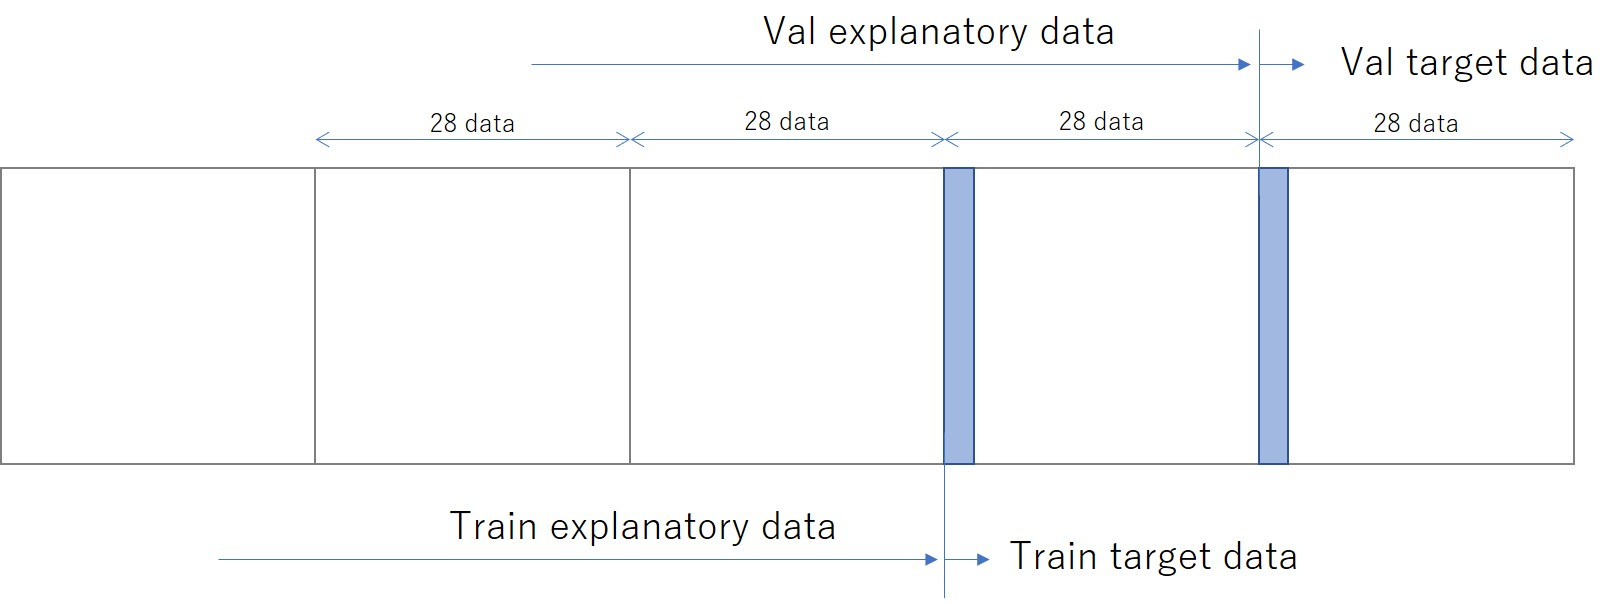

Lag features

In [ ]:
# Define function
def lag_featrues(df):
    out_df = df[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
    ###############################################################################
    # day lag 29~57 day and last year's day lag 1~28 day 
    day_lag = df.iloc[:,-28:]
    day_year_lag = df.iloc[:,-393:-365]
    day_lag.columns = [str("lag_{}_day".format(i)) for i in range(29,57)] # Rename columns
    day_year_lag.columns = [str("lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    
    # Rolling mean(3) and (7) and (28) and (84) 29~57 day and last year's day lag 1~28 day 
    rolling_3 = df.iloc[:,-730:].T.rolling(3).mean().T.iloc[:,-28:]
    rolling_3.columns = [str("rolling3_lag_{}_day".format(i)) for i in range(29,57)] # Rename columns
    rolling_3_year = df.iloc[:,-730:].T.rolling(3).mean().T.iloc[:,-393:-365]
    rolling_3_year.columns = [str("rolling3_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    
    rolling_7 = df.iloc[:,-730:].T.rolling(7).mean().T.iloc[:,-28:]
    rolling_7.columns = [str("rolling7_lag_{}_day".format(i)) for i in range(29,57)] # Rename columns
    rolling_7_year = df.iloc[:,-730:].T.rolling(7).mean().T.iloc[:,-393:-365]
    rolling_7_year.columns = [str("rolling7_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    
    rolling_28 = df.iloc[:,-730:].T.rolling(28).mean().T.iloc[:,-28:]
    rolling_28.columns = [str("rolling28_lag_{}_day".format(i)) for i in range(29,57)]
    rolling_28_year = df.iloc[:,-730:].T.rolling(28).mean().T.iloc[:,-393:-365]
    rolling_28_year.columns = [str("rolling28_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    
    rolling_84 = df.iloc[:,-730:].T.rolling(84).mean().T.iloc[:,-28:]
    rolling_84.columns = [str("rolling84_lag_{}_day".format(i)) for i in range(29,57)]
    rolling_84_year = df.iloc[:,-730:].T.rolling(84).mean().T.iloc[:,-393:-365]
    rolling_84_year.columns = [str("rolling84_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    
    # monthly lag 1~18 month
    month_lag = pd.DataFrame({})
    for i in range(1,19):
        if i == 1:
            monthly = df.iloc[:,-28*i:].T.sum().T
            month_lag["monthly_lag_{}_month".format(i)] = monthly
        else:
            monthly = df.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_lag["monthly_lag_{}_month".format(i)] = monthly
            
    # combine day lag and monthly lag
    out_df = pd.concat([out_df, day_lag], axis=1)
    out_df = pd.concat([out_df, day_year_lag], axis=1)
    out_df = pd.concat([out_df, rolling_3], axis=1)
    out_df = pd.concat([out_df, rolling_3_year], axis=1)
    out_df = pd.concat([out_df, rolling_7], axis=1)
    out_df = pd.concat([out_df, rolling_7_year], axis=1)
    out_df = pd.concat([out_df, rolling_28], axis=1)
    out_df = pd.concat([out_df, rolling_28_year], axis=1)
    out_df = pd.concat([out_df, rolling_84], axis=1)
    out_df = pd.concat([out_df, rolling_84_year], axis=1)
    out_df = pd.concat([out_df, month_lag], axis=1)
    
    ###############################################################################
    # dept_id
    group_dept = df.groupby("dept_id").sum()
    # day lag 29~57 day and last year's day lag 1~28 day 
    dept_day_lag = group_dept.iloc[:,-28:]
    dept_day_year_lag = group_dept.iloc[:,-393:-365]
    dept_day_lag.columns = [str("dept_lag_{}_day".format(i)) for i in range(29,57)]
    dept_day_year_lag.columns = [str("dept_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    # monthly lag 1~18 month
    month_dept_lag = pd.DataFrame({})
    for i in range(1,19):
        if i == 1:
            monthly_dept = group_dept.iloc[:,-28*i:].T.sum().T
            month_dept_lag["dept_monthly_lag_{}_month".format(i)] = monthly_dept
        elif i >= 7 and i < 13:
            continue
        else:
            monthly = group_dept.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_dept_lag["dept_monthly_lag_{}_month".format(i)] = monthly_dept
    # combine out df
    out_df = pd.merge(out_df, dept_day_lag, left_on="dept_id", right_index=True, how="left")
    out_df = pd.merge(out_df, dept_day_year_lag, left_on="dept_id", right_index=True, how="left")
    out_df = pd.merge(out_df, month_dept_lag, left_on="dept_id", right_index=True, how="left")
    
    ###############################################################################       
    # cat_id
    group_cat = df.groupby("cat_id").sum()
    # day lag 29~57 day and last year's day lag 1~28 day 
    cat_day_lag = group_cat.iloc[:,-28:]
    cat_day_year_lag = group_cat.iloc[:,-393:-365]
    cat_day_lag.columns = [str("cat_lag_{}_day".format(i)) for i in range(29,57)]
    cat_day_year_lag.columns = [str("cat_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    # monthly lag 1~18 month
    month_cat_lag = pd.DataFrame({})
    for i in range(1,19):
        if i == 1:
            monthly_cat = group_cat.iloc[:,-28*i:].T.sum().T
            month_cat_lag["cat_monthly_lag_{}_month".format(i)] = monthly_cat
        elif i >= 7 and i < 13:
            continue
        else:
            monthly_cat = group_cat.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_cat_lag["dept_monthly_lag_{}_month".format(i)] = monthly_cat
            
    # combine out df
    out_df = pd.merge(out_df, cat_day_lag, left_on="cat_id", right_index=True, how="left")
    out_df = pd.merge(out_df, cat_day_year_lag, left_on="cat_id", right_index=True, how="left")
    out_df = pd.merge(out_df, month_cat_lag, left_on="cat_id", right_index=True, how="left")
    
    ###############################################################################
    # store_id
    group_store = df.groupby("store_id").sum()
    # day lag 29~57 day and last year's day lag 1~28 day 
    store_day_lag = group_store.iloc[:,-28:]
    store_day_year_lag = group_store.iloc[:,-393:-365]
    store_day_lag.columns = [str("store_lag_{}_day".format(i)) for i in range(29,57)]
    store_day_year_lag.columns = [str("store_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    # monthly lag 1~18 month
    month_store_lag = pd.DataFrame({})
    for i in range(1,19):
        if i == 1:
            monthly_store = group_store.iloc[:,-28*i:].T.sum().T
            month_store_lag["store_monthly_lag_{}_month".format(i)] = monthly_store
        elif i >= 7 and i <13:
            continue
        else:
            monthly_store = group_store.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_store_lag["store_monthly_lag_{}_month".format(i)] = monthly_store
            
    # combine out df
    out_df = pd.merge(out_df, store_day_lag, left_on="store_id", right_index=True, how="left")
    out_df = pd.merge(out_df, store_day_year_lag, left_on="store_id", right_index=True, how="left")
    out_df = pd.merge(out_df, month_store_lag, left_on="store_id", right_index=True, how="left")
    
    ###############################################################################
    # state_id
    group_state = df.groupby("state_id").sum()
    # day lag 29~57 day and last year's day lag 1~28 day 
    state_day_lag = group_state.iloc[:,-28:]
    state_day_year_lag = group_state.iloc[:,-393:-365]
    state_day_lag.columns = [str("state_lag_{}_day".format(i)) for i in range(29,57)]
    state_day_year_lag.columns = [str("state_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    # monthly lag 1~18 month
    month_state_lag = pd.DataFrame({})
    for i in range(1,13):
        if i == 1:
            monthly_state = group_state.iloc[:,-28*i:].T.sum().T
            month_state_lag["state_monthly_lag_{}_month".format(i)] = monthly_state
        elif i >= 7 and i < 13:
            continue
        else:
            monthly_state = group_state.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_state_lag["state_monthly_lag_{}_month".format(i)] = monthly_state
            
    # combine out df
    out_df = pd.merge(out_df, state_day_lag, left_on="state_id", right_index=True, how="left")
    out_df = pd.merge(out_df, state_day_year_lag, left_on="state_id", right_index=True, how="left")
    out_df = pd.merge(out_df, month_state_lag, left_on="state_id", right_index=True, how="left")
    
    ###############################################################################
    # category flag
    col_list = ['dept_id', 'cat_id', 'store_id', 'state_id']
    
    df_cate_oh = pd.DataFrame({})
    for i in col_list:
        df_oh = pd.get_dummies(df[i])
        df_cate_oh = pd.concat([df_cate_oh, df_oh], axis=1)
        
    out_df = pd.concat([out_df, df_cate_oh], axis=1)
    
    return out_df

### --------------------------------------------------------------------
## Under study ) Accuracy improvement approach 
(1) Flag the day of the weekday and holidays according to the target data.<br>
(2) Review of important features<br>
(3) Noise elimination of lag feature amount. Residuals are generated using statsmodel, and lag features are created from the time series data from which the residuals have been subtracted.

### --------------------------------------------------------------------

## test prediction by LGBM and feature importance check

In [ ]:
%%time
# Features
Train_data = train.iloc[:,:-56]
Val_data = train.iloc[:,:-28]

X_train = lag_featrues(Train_data).iloc[:,5:] # select variables
y_train = train.iloc[:,-56]
X_test = lag_featrues(Val_data).iloc[:,5:]
y_test = train.iloc[:,-28]

# Create instance
lgbm = lgb.LGBMRegressor()

# Training and score
learning_rate = [0.15, 0.2, 0.25]
max_depth = [15, 20, 25]

param_grid = {'learning_rate': learning_rate, 'max_depth': max_depth}

# Fitting
cv_lgbm = GridSearchCV(lgbm, param_grid, cv=10, n_jobs =1)
cv_lgbm.fit(X_train, y_train)

print("Best params:{}".format(cv_lgbm.best_params_))

# best params
best_lg = cv_lgbm.best_estimator_

# prediction
y_train_pred_lg = best_lg.predict(X_train)
y_test_pred_lg = best_lg.predict(X_test)

print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred_lg)))
print("MSE test;{}".format(mean_squared_error(y_test, y_test_pred_lg)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred_lg)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred_lg)))

In [ ]:
# Feature importance
importance = best_lg.feature_importances_

indices = np.argsort(importance)[::-1]

# print importance
importance_df = pd.DataFrame({})
columns = []
importance_ = []
for f in range(X_train.shape[1]):
    print("%2d) %-*s %.2f" %(f+1, 30, X_train.columns[indices[f]], importance[indices[f]]))
    col = X_train.columns[indices[f]]
    imp = importance[indices[f]]
    columns.append(col)
    importance_.append(imp)
importance_df["col_name"] = columns
importance_df["importance"] = importance_

In [ ]:
# Visualization of prediction and test data
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred_lg, s=10, color="aqua", label="train data prediction", alpha=0.5)
plt.scatter(y_test, y_test_pred_lg, s=10, color="pink", label="test data prediction",  alpha=0.5)
plt.xlabel("y real data")
plt.xlim([-5,130])
plt.ylim([-5,130])
plt.ylabel("y_predictin data")
plt.title("Prediction data plot")

Predict using only variables with an importance of 1 or higher.

In [ ]:
%%time
# importance columns (>0)
imp_col = importance_df[importance_df["importance"]>0]["col_name"].values

# Train test split, select by imp_col

X_train = lag_featrues(Train_data).iloc[:,5:][imp_col] # select variables
y_train = train.iloc[:,-56]
X_test = lag_featrues(Val_data).iloc[:,5:][imp_col]
y_test = train.iloc[:,-28]

# Create instance
lgbm = lgb.LGBMRegressor()

# Training and score
learning_rate = [0.15, 0.2, 0.25]
max_depth = [15, 20, 25]

param_grid = {'learning_rate': learning_rate, 'max_depth': max_depth}

# Fitting
cv_lgbm = GridSearchCV(lgbm, param_grid, cv=10, n_jobs =1)
cv_lgbm.fit(X_train, y_train)

print("Best params:{}".format(cv_lgbm.best_params_))

# best params
best_lg = cv_lgbm.best_estimator_

# prediction
y_train_pred_lg = best_lg.predict(X_train)
y_test_pred_lg = best_lg.predict(X_test)

print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred_lg)))
print("MSE test;{}".format(mean_squared_error(y_test, y_test_pred_lg)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred_lg)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred_lg)))

# Predict sales for next 2 month.
1st, predict with train data next 28days.
2nd, predict with train data and 1st prediction data next 28days.

In [ ]:
%%time
# Prediction last 28 days by roop

def lgbm_pred(X_train, y_train, X_test):
    lgbm = lgb.LGBMRegressor(learning_rate=0.2, max_depth=20)
    # Fitting
    lgbm.fit(X_train, y_train)
    # prediction
    y_pred = lgbm.predict(X_test)
    return y_pred

# Features
# Features
Train_data = train.iloc[:,:-56]
Y_train = train.iloc[:,-56:-28]
Val_data = train.iloc[:,:-28]
Y_test = train.iloc[:,-28:]

Pred_data = pd.DataFrame({})
for d in range(0,28):
    if d == 0:
        X_train = lag_featrues(Train_data).iloc[:,5:][imp_col] # select variables
        y_train = Y_train.iloc[:,d]
        X_test = lag_featrues(Val_data).iloc[:,5:][imp_col]
        
        # Train test split, select by imp_col
        pred = lgbm_pred(X_train, y_train, X_test)
        Pred_data["pred_{}_day".format(1+d)] = pred
    else:
        X_train = lag_featrues(Train_data.iloc[:,:-1])[imp_col]
        y_train = Y_train.iloc[:,d]
        X_test = lag_featrues(Train_data)[imp_col][imp_col]
        
        # Train test split, select by imp_col
        pred = lgbm_pred(X_train, y_train, X_test)
        Pred_data["pred_{}_day".format(1+d)] = pred

In [ ]:
# Confirming prediction result
MSE = []
R2_score = []

for i in range(Y_test.shape[1]):
    mse = mean_squared_error(Y_test.iloc[:,i], Pred_data.iloc[:,i])
    r2 = r2_score(Y_test.iloc[:,i], Pred_data.iloc[:,i])
    MSE.append(mse)
    R2_score.append(r2)

month_pred_score = pd.DataFrame({"day":range(1,29),
                                 "MSE":MSE,
                                 "R2":R2_score})

# Visualization check
fig, ax = plt.subplots(1,2, figsize=(20, 6))

ax[0].bar(month_pred_score["day"], month_pred_score["MSE"])
ax[0].set_xlabel("Prediction day")
ax[0].set_ylabel("MSE")

ax[1].bar(month_pred_score["day"], month_pred_score["R2"])
ax[1].set_xlabel("Prediction day")
ax[1].set_ylabel("R2 score")

# Submission data prediction

In [ ]:
%%time
# Prediction next 56 days by roop

# Features
Train_data = train.iloc[:,:-28]
Test_data = train
Y_train = train.iloc[:,-28:]

Pred_data_val = pd.DataFrame({})
Pred_data_eval = pd.DataFrame({})

for d in range(0,28):
    X_train = lag_featrues(Train_data)[imp_col] # select variables
    y_train = Y_train.iloc[:,d]
    X_test = lag_featrues(Test_data)[imp_col]
        
    # Train test split, select by imp_col
    pred = lgbm_pred(X_train, y_train, X_test)
    Pred_data_val["pred_{}_day".format(1+d)] = pred

In [ ]:
Train_data = train
Test_data = pd.concat([train, Pred_data_val], axis=1)
Y_train = Pred_data_val

for d in range(0,28):
    X_train = lag_featrues(Train_data)[imp_col]
    y_train = Y_train.iloc[:,d]
    X_test = lag_featrues(Test_data)[imp_col]
        
    # Train test split, select by imp_col
    pred = lgbm_pred(X_train, y_train, X_test)
    Pred_data_eval["pred_{}_day".format(1+d)] = pred

In [ ]:
Pred_data_val.columns = sample.loc[:,"F1":].columns
Pred_data_eval.columns = sample.loc[:,"F1":].columns

# concat val data and eval data
submit_data = pd.concat([Pred_data_val, Pred_data_eval])
submit_data = submit_data.reset_index().drop("index", axis=1)

col = sample.loc[:,'F1':].columns

sample[col] = submit_data

# Submission data
sample.to_csv("submission.csv", index=False)

# Submission data
sample.round(0).to_csv("submission_r.csv", index=False)

In [ ]:
# Predictin of validataion
sample.iloc[:30490,:].describe()

In [ ]:
# Predictin of evaluation
sample.iloc[30490:,:].describe()

# Next steps
Try to improve accuracy.<br>

Review the features and create new features to improve accuracy.<br>
Adjust parameters to improve accuracy.